# **Table Structure Detection and Data Extraction**

## **1. Business Problem**

### **Description :**

In recent years, there has been a rapid adoption of Computer Vision
techniques in a wide range of tasks - ranging from Autonomous vehicles
and Medical diagnosis to Military surveillance.

Another pertinent task would be the extraction of specific information from documents or images. With the widespread use of mobile phones and scanners to photograph and upload documents, the need for extracting the information trapped in unstructured document images such as retail receipts, insurance claim forms and financial invoices has become more acute. A major hurdle to this task is that these images/documents often contain information in the form of tables and extracting data accurately from tables can be a tricky task. 

**Automatic Table Information Extraction** involves precisely detecting the position of the table(s) and also accurately extracting information from the rows and columns of the table i.e from the table cells :

<img src= 'https://nanonets.com/blog/content/images/2020/01/Comp-5-1.gif'>

Some prior approaches have attempted to solve the tasks of table detection and data extraction from tables indpendently .Some newer approaches like TableNet have tried to provide an end to end solution to both the tasks. Traditionally, one could manually check and copy data from the files but automating the process would be more time-efficient and less erroneous .  


### **Problem Statement :**

Build a ML system that automates the process of data extraction from tables in a document. It identifies the presence of table(s) in an Image file and pulls out the data accurately from its table cells.

### **Real World / Business Objectives and Constraints :**

1. Extract the data present inside the table(s) as accurately as possible.
2. There is no strict latency constraints but the data should be fetched and populated within a couple of minutes.
3. Inaccurate extraction of data is undesirable and would defeat the purpose of automating the task.

## **2. Data Information :**

 
*   We will be using the **MARMOT Dataset** for training and evaluating our models.
*   It consists of about **500 images** and their corresponding table & column annotations. Annotation files are present in xml format.
*   We will use these annotations to generate the table & column segmentation masks for each image.




## **3. ML Problem Formulation :**

### **Type of Machine Learning Problem :**

For extracting data from table(s) present in an Image :


*   The columns and tables have to be segmented from the image. Thus it is an **Image Segmentation** i.e pixel-wise classification task.
*   Then we need to pass the table and column segments through an OCR(Object Character Recognition) tool in order to retrieve the text present in the table cells.



### **Performance Metrics :**

*The evaluation metric used in this classification task is F1-score :*


---


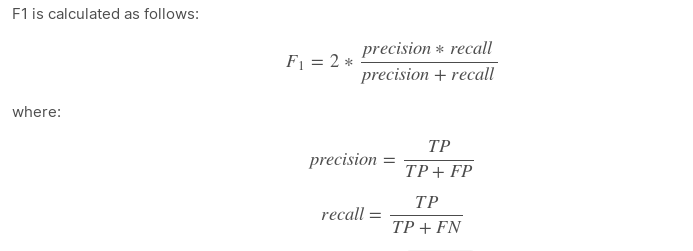


---

*  *Precison is the measure of the correctly identified positive cases from all the predicted positive cases*
*  *Recall is the measure of the correctly identified positive cases from all the actual positive cases*
*  *F1-Score is the harmonic mean of Precision and Recall. This used as a evalutation metric since it penalizes false positives and false negatives equally. It is a **preferred metric** in cases where class imbalance exists.*



## **4. Exploratory Data Analysis**

### **Loading Data :**

*Importing necessary modules*

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
import gc
import pytesseract
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, Embedding, Flatten, Conv2DTranspose, concatenate, UpSampling2D,Conv2D, MaxPooling1D
from google.colab.patches import cv2_imshow
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%load_ext tensorboard

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (26.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

#### **Downloading Data :**

In [ ]:
!gdown "https://drive.google.com/uc?id=1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp"
!unzip "/content/Marmot_data.zip" -d "/content/Data"

Downloading...
From: https://drive.google.com/uc?id=1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp
To: /content/Marmot_data.zip
68.8MB [00:00, 111MB/s]
Archive:  /content/Marmot_data.zip
replace /content/Data/10.1.1.8.2198_13.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### **Checking for Missing Data :**

In [ ]:
#Counts for document and annotation files 
fc, annc = 0,0

for f in os.listdir("/content/Data/"):
  if f.endswith("xml") and os.path.isfile("/content/Data/"+ f[:-4] +".bmp"):
    annc += 1
  if f.endswith("bmp"):
    fc += 1

print("Total number of document files(bmp)         :", fc)
print("Number of documents having annotations(xml) :", annc)

Total number of document files(bmp)         : 509
Number of documents having annotations(xml) : 494


* *494 out of 509 documents have annotations. Thus we'll use these for Training & Testing and ignore the rest.*

### **Processing Data :**

* *We have 495 documents in ".bmp" format and their column annotations in ".xml" format*




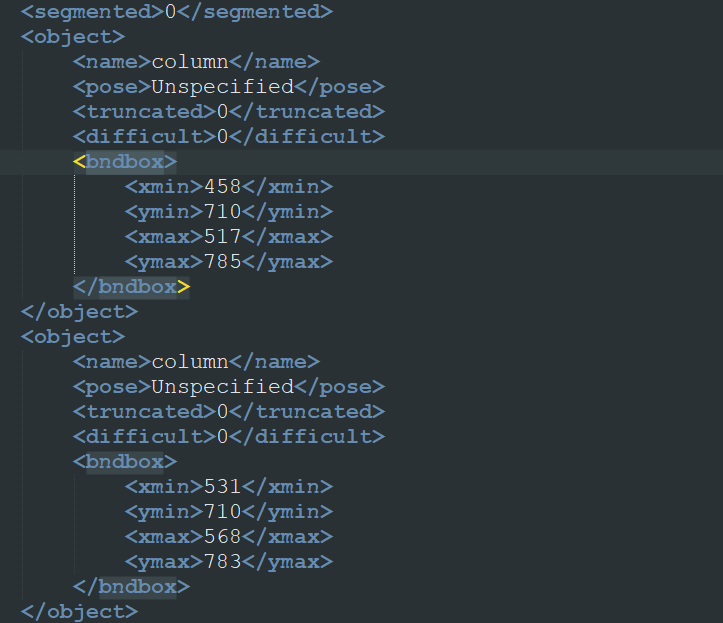








* *The column dimensions are present inside the "**bndbox**" i.e the bounding boxes. They are denoted by xmin, xmax, ymin and ymax.*
* *Using this information, we have to generate the Column as well as the Table masks.*

In [ ]:
#Calculates Euclidean distance between 2 points
def euc_dist(point1, point2):
    dist = np.linalg.norm(point1 - point2)
    return dist

#Saves Image to Disk
def save_image(name, image_arr):
  im = Image.fromarray(image_arr)
  im.save(name)

In [ ]:
def generate_mask(path) :
  ''' Generates Column & Table Masks from Annotations'''

  # reading xml file
  tree = ET.parse("/content/Data/"+path+".xml")
  root = tree.getroot()


  size = root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)
  depth = int(size.find('depth').text)

  # creating empty mask image
  col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
  table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

  table_xmin = 0
  table_ymin = 0
  table_xmax = 0
  table_ymax = 0
  prev_dist = 0
  dist = 0
  forward_flag = False
  backward_flag = False
  newtable_flag = True
  col_cnt = 0

  # creating empty masks
  col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
  table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

  # retrieving the objects that contain the annotations 
  objects = tree.findall('object')

  for index, object in enumerate(objects):
    bndbox = object.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)
        
    col_mask_empty[ymin:ymax, xmin:xmax] = 255
        
    col_len.append(ymax-ymin)  
    col_cnt += 1  
        
    if index == 0:
      prev_xmin = int(bndbox.find('xmin').text)
      prev_ymin = int(bndbox.find('ymin').text)
      prev_xmax = int(bndbox.find('xmax').text)
      prev_ymax = int(bndbox.find('ymax').text)
            
                
    else:  
      if xmin > prev_xmin and newtable_flag:
        table_xmin = prev_xmin
        table_ymin = prev_ymin
        newtable_flag = False
        forward_flag = True
        backward_flag = False

      if xmin < prev_xmin and newtable_flag:

        table_xmax = prev_xmax
        table_ymax = prev_ymax
                
                
        newtable_flag = False
        backward_flag = True
        forward_flag = False



      if forward_flag:
        dist = euc_dist(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))

        if prev_dist == 0:
          prev_dist = dist
        else:
          if int(np.divide(dist, prev_dist)) > 5:
            newtable_flag = True
            table_mask_empty[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255

            prev_dist = 0
            num_cols.append(col_cnt)
            col_cnt = 0
                        
          if index==len(objects)-1:
            newtable_flag = True
            table_mask_empty[table_ymin:ymax, table_xmin:xmax] = 255
            

            prev_dist = 0
            num_cols.append(col_cnt)
            col_cnt = 0

      if backward_flag:
        dist = euc_dist(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))

        if prev_dist == 0:
          prev_dist = dist
        else:
          if int(np.divide(dist, prev_dist)) > 5 or index==len(objects)-1:
            newtable_flag = True
            table_mask_empty[ymin:table_ymax, xmin:table_xmax] = 255

            prev_dist = 0
            num_cols.append(col_cnt)
            col_cnt = 0            
                
    prev_xmin = int(bndbox.find('xmin').text)
    prev_ymin = int(bndbox.find('ymin').text)
    prev_xmax = int(bndbox.find('xmax').text)
    prev_ymax = int(bndbox.find('ymax').text)
    prev_dist = dist
            
  filenames.append(path)
  save_image(table_mask_path+"/" + path+"_tbl.jpeg", table_mask_empty)
  save_image(col_mask_path+"/" + path+"_col.jpeg", col_mask_empty)

In [ ]:
#!rm -rf ./Data/
!rm -rf ./Column_Mask/
!rm -rf ./Table_Mask/

In [ ]:
table_mask_path = "Table_Mask"
col_mask_path = "Column_Mask"

if os.path.isdir(table_mask_path) == False:
  os.mkdir(table_mask_path)
if os.path.isdir(col_mask_path) == False:
  os.mkdir(col_mask_path)

filenames = []
col_len, num_cols  = [], []

for filename in os.listdir("/content/Data/"):
  if filename.endswith("xml") and os.path.isfile("/content/Data/"+ filename[:-4] +".bmp"):
    generate_mask(filename[:-4])

* *Generating Table & Column Masks from the annotations* 

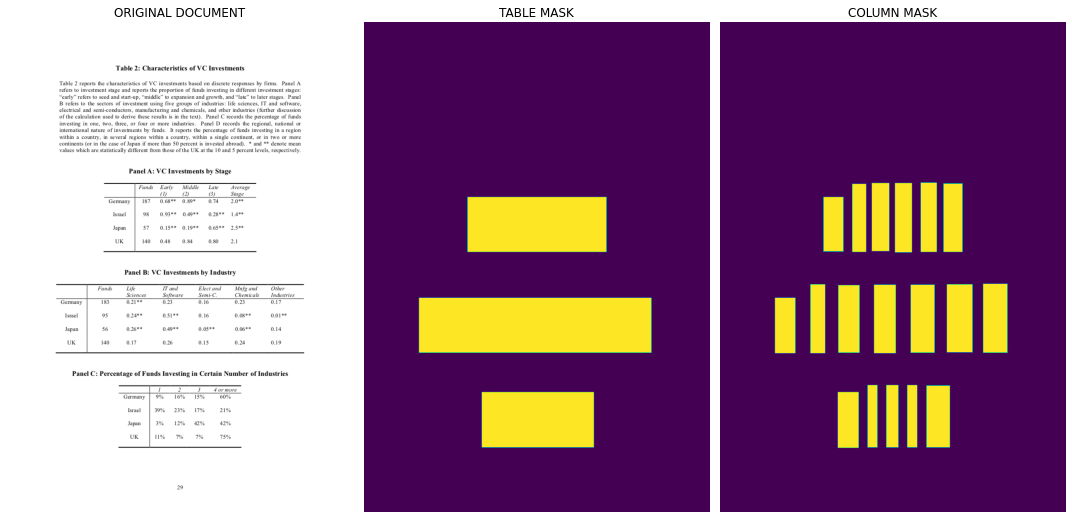

In [ ]:
fig = plt.figure(figsize=(15, 20))

img = Image.open("/content/Data/10.1.1.1.2023_31.bmp")
fig.add_subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.title("ORIGINAL DOCUMENT")

img = Image.open("/content/Table_Mask/10.1.1.1.2023_31_tbl.jpeg")
fig.add_subplot(1, 3, 2)
plt.imshow(img)
plt.axis('off')
plt.title("TABLE MASK")

img = Image.open("/content/Column_Mask/10.1.1.1.2023_31_col.jpeg")
fig.add_subplot(1, 3, 3)
plt.imshow(img)
plt.axis('off')
plt.title("COLUMN MASK")


fig.tight_layout()

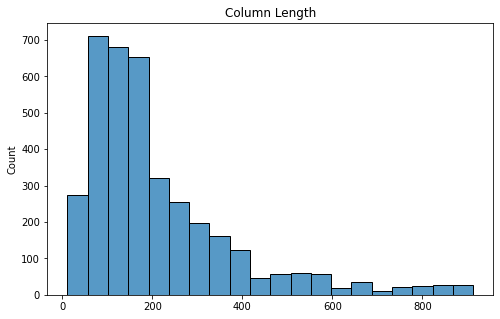

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(x = col_len, bins = 20)
plt.title("Column Length")
plt.show()

* *Most columns are short or of average length , except a few which have a length > 400.*

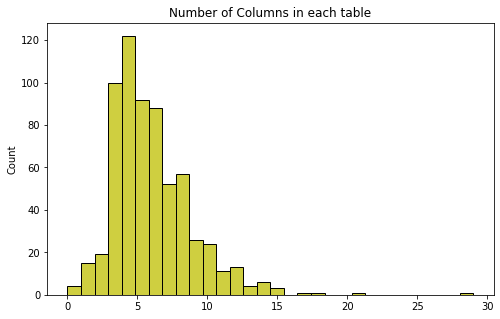

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(x = num_cols, bins = 30, color = 'y')
plt.title("Number of Columns in each table")
plt.show()

* *Most tables have 3 to 8 columns.*

## **Preparing Train and Test Data**

In [ ]:
images   = []
tbl_mask = []
col_mask = []
df = pd.DataFrame()

for fname in filenames :
  images.append(str("/content/Data/"+fname+".bmp"))
  tbl_mask.append(str("/content/Table_Mask/"+fname+"_tbl.jpeg"))
  col_mask.append(str("/content/Column_Mask/"+fname+"_col.jpeg"))

df["Image"] = images
df["Table_Mask"] = tbl_mask
df["Column_Mask"] = col_mask

df.head()

Image  ...                                       Column_Mask
0     /content/Data/10.1.1.1.2112_4.bmp  ...     /content/Column_Mask/10.1.1.1.2112_4_col.jpeg
1     /content/Data/10.1.1.6.2366_6.bmp  ...     /content/Column_Mask/10.1.1.6.2366_6_col.jpeg
2  /content/Data/10.1.1.190.2735_45.bmp  ...  /content/Column_Mask/10.1.1.190.2735_45_col.jpeg
3     /content/Data/10.1.1.6.2223_6.bmp  ...     /content/Column_Mask/10.1.1.6.2223_6_col.jpeg
4    /content/Data/10.1.1.20.2120_8.bmp  ...    /content/Column_Mask/10.1.1.20.2120_8_col.jpeg

[5 rows x 3 columns]

* *Storing all the Image and their Mask paths in a dataframe*

In [ ]:
Train, Test = train_test_split(df, test_size = 0.2)

Train_Data = tf.data.Dataset.from_tensor_slices(
    (
        Train["Image"].values,
        Train["Table_Mask"].values,
        Train["Column_Mask"].values
    )
)

Test_Data  =  tf.data.Dataset.from_tensor_slices(
    (
        Test["Image"].values,
        Test["Table_Mask"].values,
        Test["Column_Mask"].values
    )
)

* *Train-Test Split*

In [ ]:

@tf.function
def load_images(doc, tbl_mask, col_mask):
  """Reads the Image & Mask Files, decodes and preprocesses them"""

  doc = tf.io.read_file(doc)
  doc = tf.io.decode_bmp(doc, channels=3)
  doc = tf.image.resize(doc, [1024,1024])
  doc = tf.cast(doc, tf.float32) / 255.0

  tbl_mask = tf.io.read_file(tbl_mask)
  tbl_mask = tf.io.decode_jpeg(tbl_mask, channels=1)
  tbl_mask = tf.image.resize(tbl_mask, [1024,1024])
  tbl_mask = tf.cast(tbl_mask, tf.float32) / 255.0
  
  col_mask = tf.io.read_file(col_mask)
  col_mask = tf.io.decode_jpeg(col_mask, channels=1)
  col_mask = tf.image.resize(col_mask, [1024,1024])
  col_mask = tf.cast(col_mask, tf.float32) / 255.0
  
  return doc, {"Table_mask" : tbl_mask, "Column_mask" : col_mask}


def load_data(BATCH_SIZE, BUFFER_SIZE):
  """Loads data in batches for Training & Testing"""

  train_steps = len(Train) // BATCH_SIZE
  val_steps = len(Test) // BATCH_SIZE

  train_dataset = Train_Dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #.prefetch(tf.data.AUTOTUNE)
  test_dataset  = Test_Dataset.batch(BATCH_SIZE)

  return train_dataset, test_dataset, train_steps, val_steps


Train_Dataset = Train_Data.map(load_images, num_parallel_calls= tf.data.AUTOTUNE)
Test_Dataset  = Test_Data.map(load_images, num_parallel_calls= tf.data.AUTOTUNE)

* *Prepared Train and Test Datasets*

## **Model Building :**

In [ ]:
from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, Embedding, Flatten, Conv2DTranspose, concatenate, UpSampling2D,Conv2D, MaxPooling1D

### **TABLENET :**

In [ ]:
class tbl_decoder(tf.keras.layers.Layer):
  def __init__(self, name = "Table_mask"):
    super().__init__(name = name)
    self.conv1 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.umsample1 = UpSampling2D(size = (2,2),)
    self.umsample2 = UpSampling2D(size = (2,2),)
    self.umsample3 = UpSampling2D(size = (2,2),)
    self.umsample4 = UpSampling2D(size = (2,2),)
    self.convtranspose = Conv2DTranspose( filters=3, kernel_size=3, strides=2, padding = 'same')

  def call(self, X):

    input,pool_3,pool_4 = X[0],X[1],X[2]
    x = self.conv1(input)
    x = self.umsample1(x)
    x = concatenate([x, pool_4])
    x = self.umsample2(x)
    x = concatenate([x, pool_3])
    x = self.umsample3(x)
    x = self.umsample4(x)
    x = self.convtranspose(x)

    return x

In [ ]:
class col_decoder(tf.keras.layers.Layer):
  def __init__(self, name = "Column_mask"):
    super().__init__(name = name)
    self.conv1 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.drop  = Dropout(0.8)
    self.conv2 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.umsample1 = UpSampling2D(size = (2,2),)
    self.umsample2 = UpSampling2D(size = (2,2),)
    self.umsample3 = UpSampling2D(size = (2,2),)
    self.umsample4 = UpSampling2D(size = (2,2),)
    self.convtranspose = Conv2DTranspose( filters=3, kernel_size=3, strides=2, padding = 'same')

  def call(self, X):

    input,pool_3,pool_4 = X[0],X[1],X[2]
    x = self.conv1(input)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.umsample1(x)
    x = concatenate([x, pool_4])
    x = self.umsample2(x)
    x = concatenate([x, pool_3])
    x = self.umsample3(x)
    x = self.umsample4(x)
    x = self.convtranspose(x)

    return x

In [ ]:
input = Input(shape=(1024,1024,3))
vgg19 = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_tensor=input, classes= 1000)

x = vgg19.output
pool_3 = vgg19.get_layer('block3_pool').output
pool_4 = vgg19.get_layer('block4_pool').output

x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(x)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)

Table_Decoder  = tbl_decoder()
Column_Decoder = col_decoder()

output1 = Table_Decoder([x, pool_3, pool_4])
#output1 = Activation(activation='relu', name = "Table_mask")(output1)
output2 = Column_Decoder([x, pool_3, pool_4])
#output2 = Activation(activation='relu', name = "Column_mask")(output2)

model = Model(inputs = input, outputs= [output1,output2], name = "TableNet")
model.summary()

Model: "TableNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 1024, 1024, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 1024, 1024, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 512, 512, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

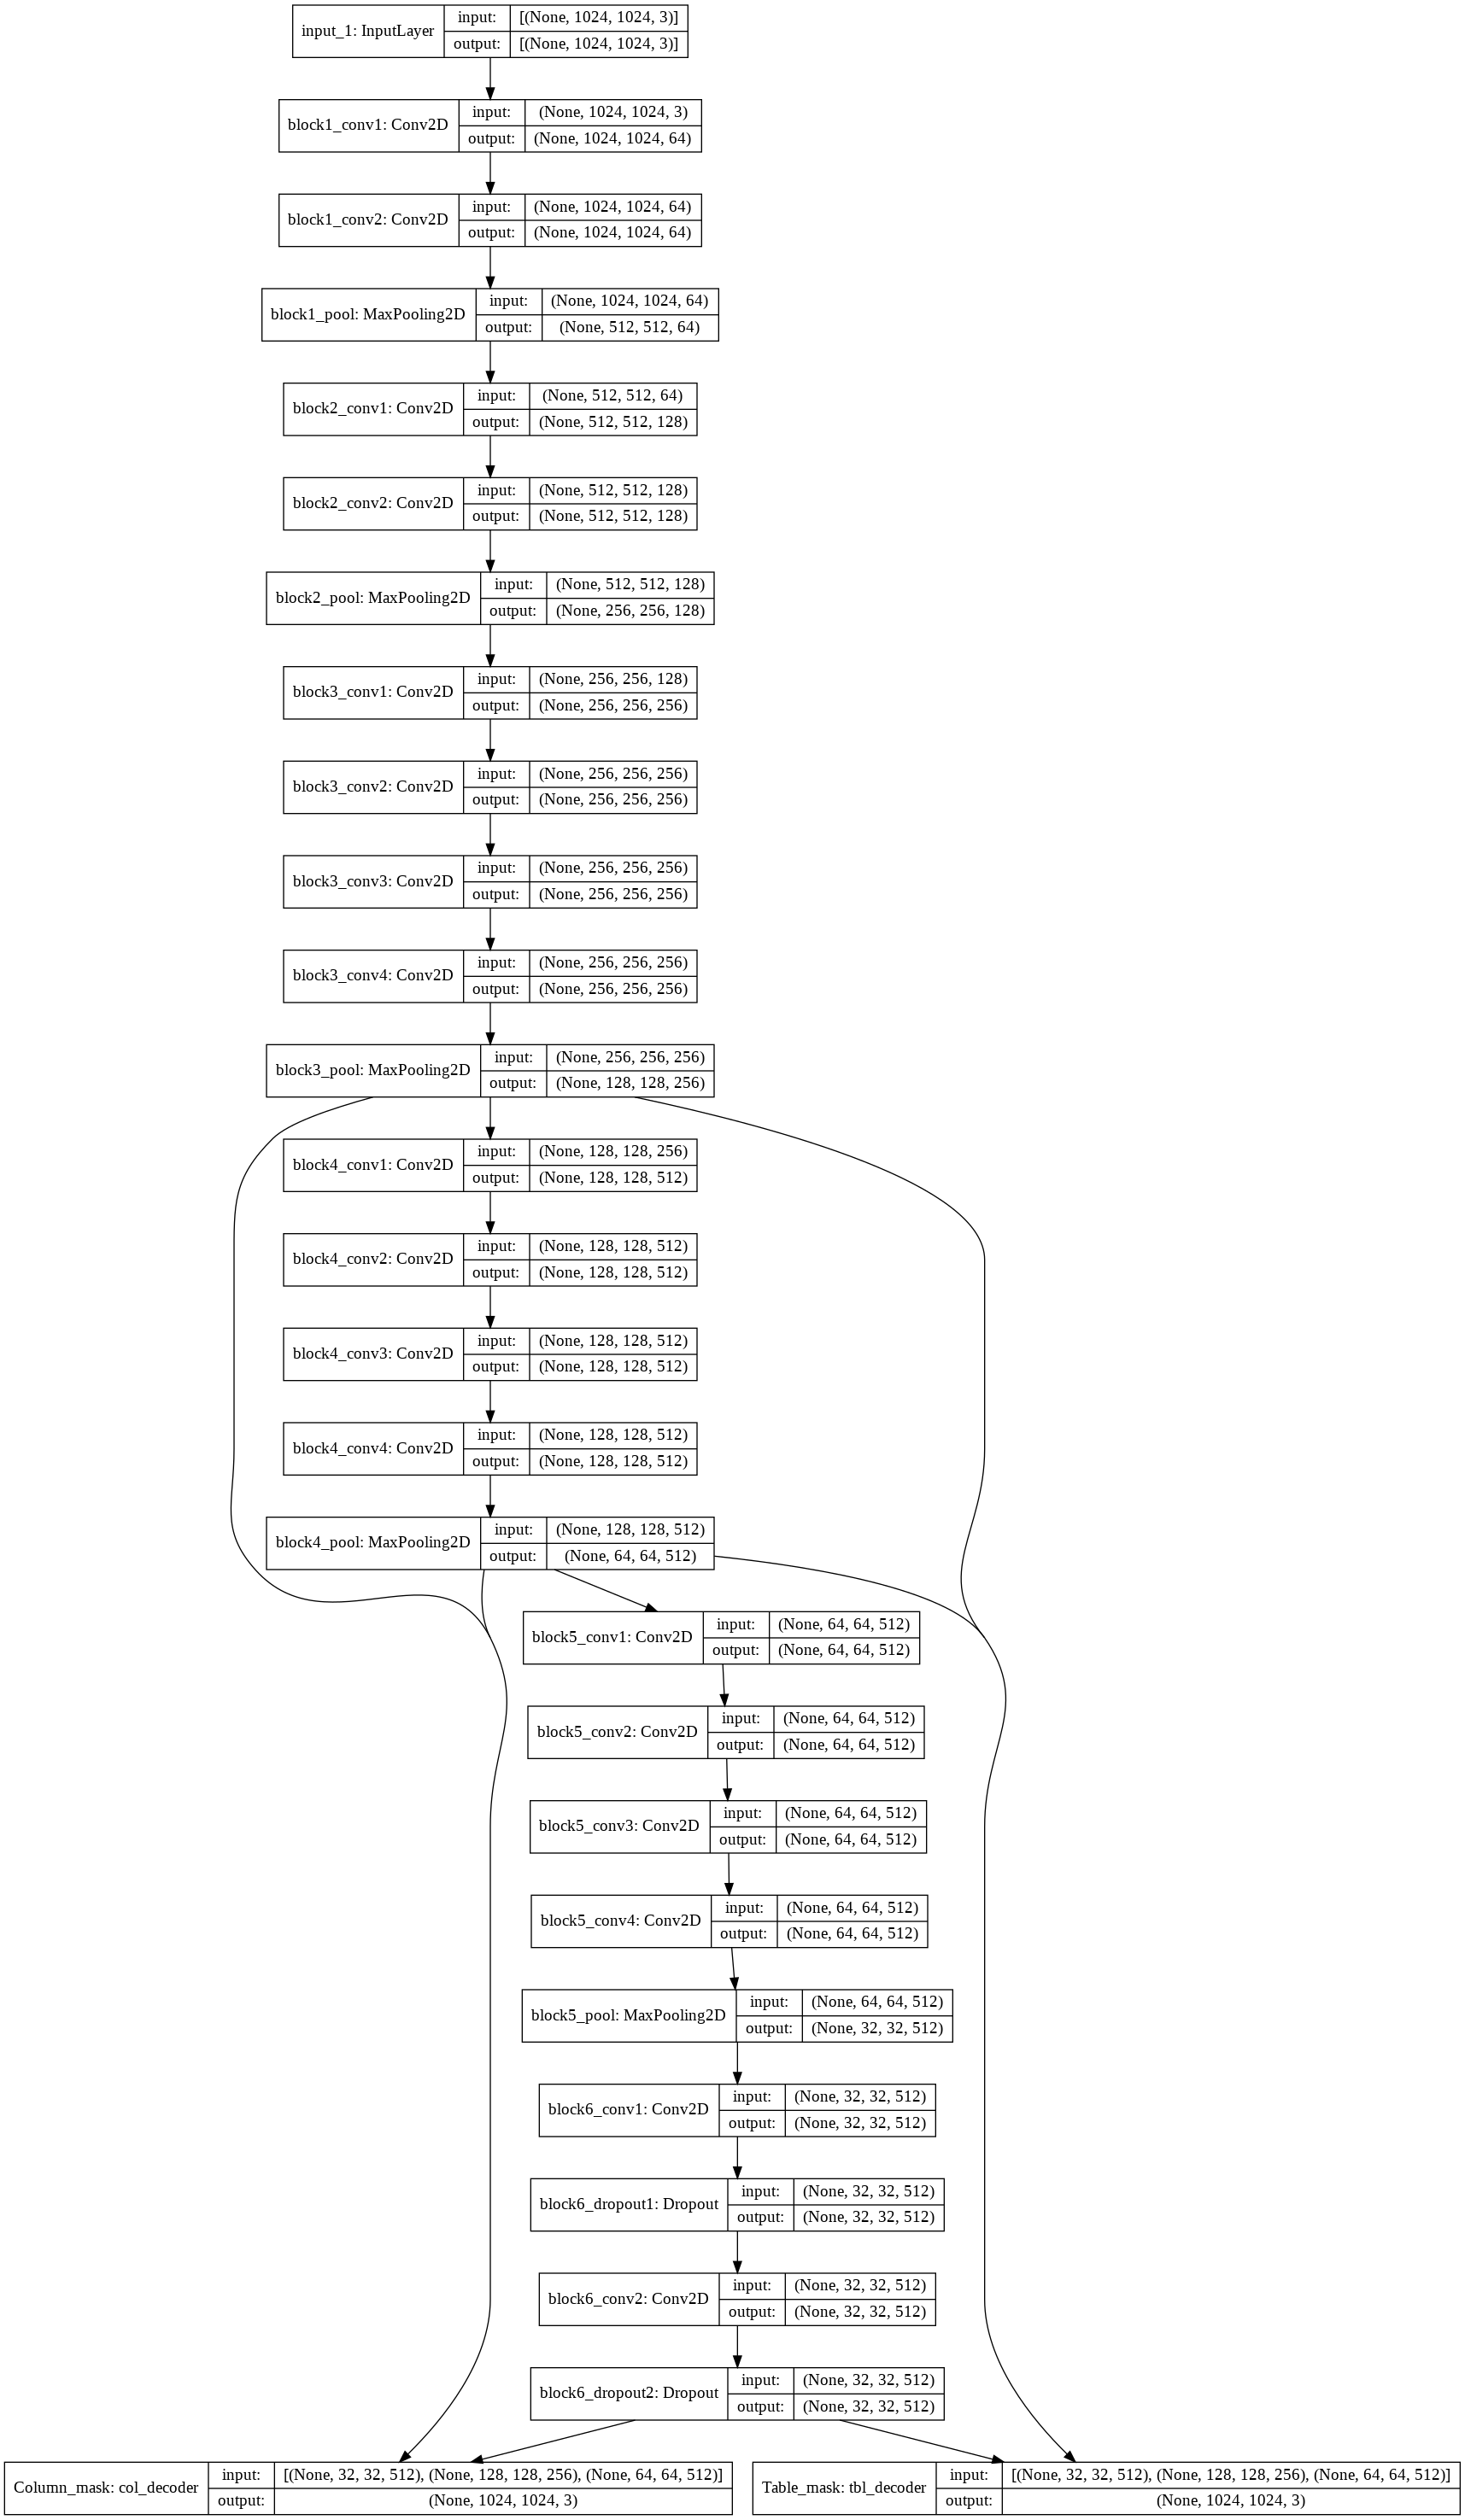

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Model Training:**

In [ ]:
!rm -rf ./logs/fit/

In [ ]:
!rm -rf ./model_save/

In [ ]:
train_dataloader, test_dataloader, train_steps, val_steps = load_data(BATCH_SIZE = 1, BUFFER_SIZE = 10)

In [ ]:
losses = {"Table_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
          "Column_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)}

loss_weights = {"Table_mask" : 2.0, 
                "Column_mask" : 1.0}

model.compile(optimizer= tf.keras.optimizers.Adam(0.0001, beta_1=0.8), loss = losses, loss_weights=loss_weights, metrics = ['accuracy']) #, F1Score(num_classes=2, threshold=0.5)])

In [ ]:
filepath="model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,  monitor='val_loss' ,save_best_only=True, mode='auto', verbose = 1 )


hist = model.fit(train_dataloader, epochs =50, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/50
395/395 [==============================] - 190s 391ms/step - loss: 0.8854 - Table_mask_loss: 0.3063 - Column_mask_loss: 0.2727 - Table_mask_accuracy: 0.8781 - Column_mask_accuracy: 0.8792 - val_loss: 0.6993 - val_Table_mask_loss: 0.2238 - val_Column_mask_loss: 0.2516 - val_Table_mask_accuracy: 0.9023 - val_Column_mask_accuracy: 0.8816

Epoch 00001: val_loss improved from inf to 0.69926, saving model to model_save/weights-01-0.6993.hdf5
Epoch 2/50
395/395 [==============================] - 146s 369ms/step - loss: 0.5365 - Table_mask_loss: 0.1824 - Column_mask_loss: 0.1718 - Table_mask_accuracy: 0.9173 - Column_mask_accuracy: 0.9060 - val_loss: 0.8287 - val_Table_mask_loss: 0.2477 - val_Column_mask_loss: 0.3332 - val_Table_mask_accuracy: 0.9108 - val_Column_mask_accuracy: 0.8857

Epoch 00002: val_loss did not improve from 0.69926
Epoch 3/50
395/395 [==============================] - 145s 368ms/step - loss: 0.4873 - Table_mask_loss: 0.1601 - Column_mask_loss: 0.1672 - Table_mas

In [ ]:
losses = {"Table_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
          "Column_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)}

loss_weights = {"Table_mask" : 1.0, 
                "Column_mask" : 1.0}

model.compile(optimizer= tf.keras.optimizers.Adam(0.0001, beta_1=0.8), loss = losses, loss_weights=loss_weights, metrics = ['accuracy']) #, F1Score(num_classes=2, threshold=0.5)])

In [ ]:
filepath="model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,  monitor='val_loss' ,save_best_only=True, mode='auto', verbose = 1 )

csvlog = tf.keras.callbacks.CSVLogger("/content/results.csv")

hist = model.fit(train_dataloader, epochs =80, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint, csvlog])

Epoch 1/80
395/395 [==============================] - 335s 732ms/step - loss: 0.1694 - Table_mask_loss: 0.0732 - Column_mask_loss: 0.0962 - Table_mask_accuracy: 0.9660 - Column_mask_accuracy: 0.9374 - val_loss: 0.3556 - val_Table_mask_loss: 0.2473 - val_Column_mask_loss: 0.1083 - val_Table_mask_accuracy: 0.9418 - val_Column_mask_accuracy: 0.9358

Epoch 00001: val_loss improved from inf to 0.35556, saving model to model_save/weights-01-0.3556.hdf5
Epoch 2/80
395/395 [==============================] - 282s 715ms/step - loss: 0.1361 - Table_mask_loss: 0.0548 - Column_mask_loss: 0.0813 - Table_mask_accuracy: 0.9706 - Column_mask_accuracy: 0.9410 - val_loss: 0.3703 - val_Table_mask_loss: 0.2290 - val_Column_mask_loss: 0.1413 - val_Table_mask_accuracy: 0.9484 - val_Column_mask_accuracy: 0.9246

Epoch 00002: val_loss did not improve from 0.35556
Epoch 3/80
395/395 [==============================] - 281s 713ms/step - loss: 0.1211 - Table_mask_loss: 0.0481 - Column_mask_loss: 0.0730 - Table_mas

In [ ]:
filepath="model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,  monitor='val_loss' ,save_best_only=True, mode='auto', verbose = 1 )


hist = model.fit(train_dataloader, epochs =60, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/60
395/395 [==============================] - 333s 725ms/step - loss: 0.1049 - Table_mask_loss: 0.0392 - Column_mask_loss: 0.0656 - Table_mask_accuracy: 0.9752 - Column_mask_accuracy: 0.9461 - val_loss: 0.1485 - val_Table_mask_loss: 0.0803 - val_Column_mask_loss: 0.0682 - val_Table_mask_accuracy: 0.9635 - val_Column_mask_accuracy: 0.9486

Epoch 00001: val_loss improved from inf to 0.14850, saving model to model_save/weights-01-0.1485.hdf5
Epoch 2/60
395/395 [==============================] - 281s 711ms/step - loss: 0.0929 - Table_mask_loss: 0.0323 - Column_mask_loss: 0.0606 - Table_mask_accuracy: 0.9781 - Column_mask_accuracy: 0.9479 - val_loss: 0.1437 - val_Table_mask_loss: 0.0732 - val_Column_mask_loss: 0.0705 - val_Table_mask_accuracy: 0.9678 - val_Column_mask_accuracy: 0.9475

Epoch 00002: val_loss improved from 0.14850 to 0.14367, saving model to model_save/weights-02-0.1437.hdf5
Epoch 3/60
395/395 [==============================] - 280s 709ms/step - loss: 0.1029 - Table_m

**Plotting the metric curves :**

In [4]:
df = pd.read_csv("/content/TrainingLogs.txt")
df.head()

epoch  Column_mask_accuracy  ...  val_Table_mask_loss  val_loss
0      0              0.865139  ...             0.337704  1.036710
1      1              0.882519  ...             0.334088  1.021929
2      2              0.898247  ...             0.218252  0.820223
3      3              0.905912  ...             0.193564  0.724467
4      4              0.909222  ...             0.233322  0.868483

[5 rows x 11 columns]

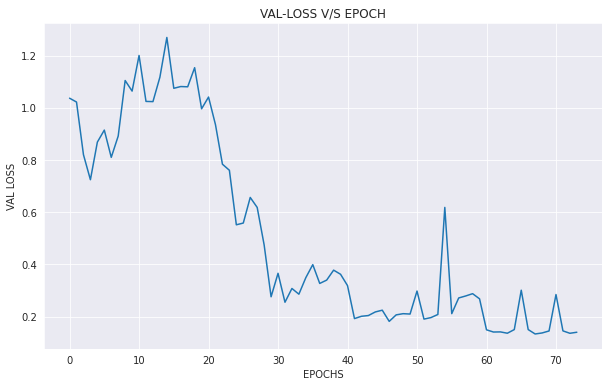

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.plot("epoch", "val_loss", data = df)
plt.xlabel("EPOCHS")
plt.ylabel("VAL LOSS")
plt.title("VAL-LOSS V/S EPOCH")
plt.show()

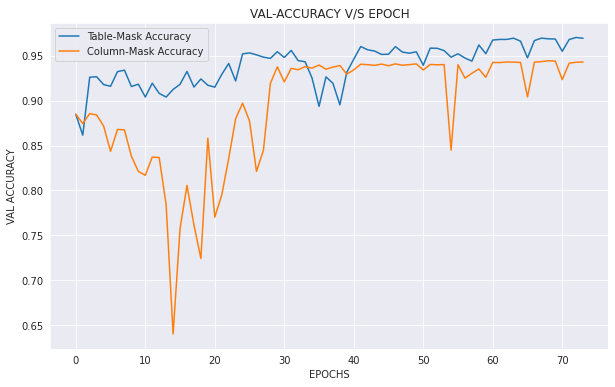

In [18]:
plt.figure(figsize=(10,6))

plt.plot("epoch", "val_Table_mask_accuracy", data = df, label ="Table-Mask Accuracy")
plt.plot("epoch", "val_Column_mask_accuracy", data = df, label ="Column-Mask Accuracy")
plt.xlabel("EPOCHS")
plt.ylabel("VAL ACCURACY")
plt.title("VAL-ACCURACY V/S EPOCH")
plt.legend()
plt.show()

#### **Getting Predictions :**

In [ ]:
def get_mask(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

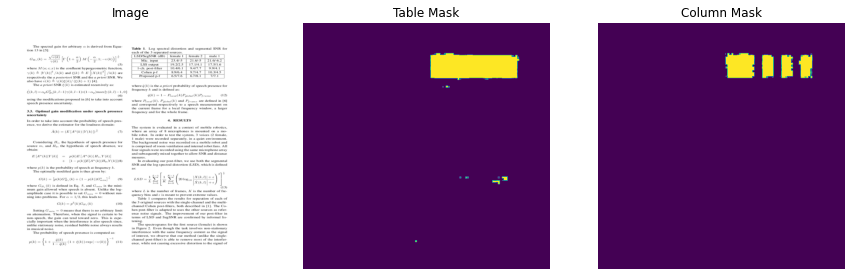

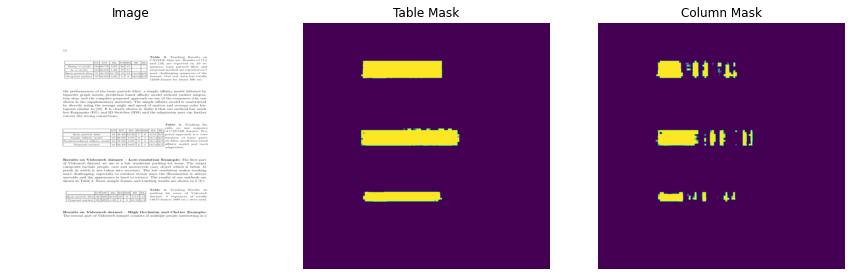

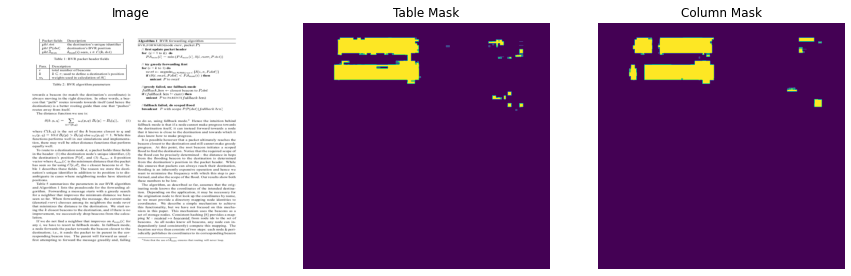

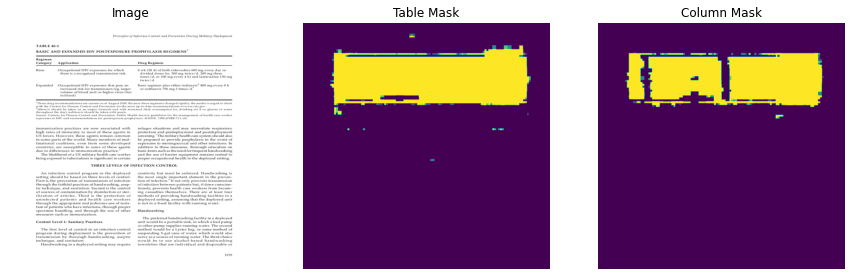

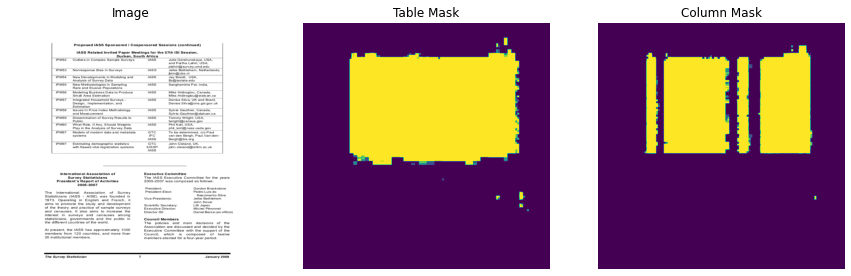

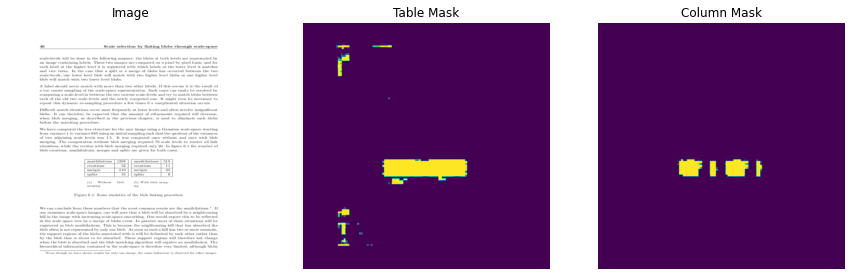

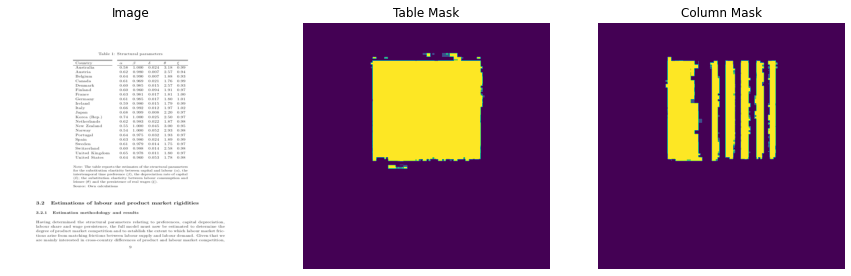

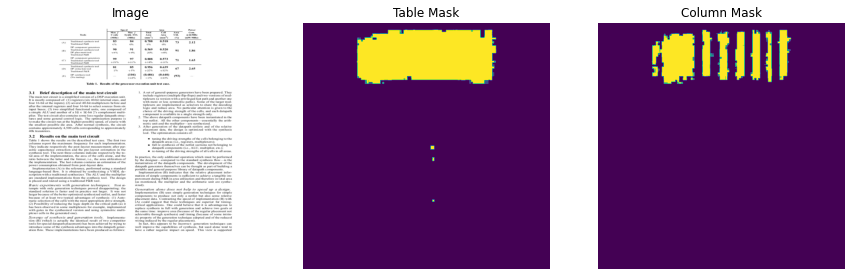

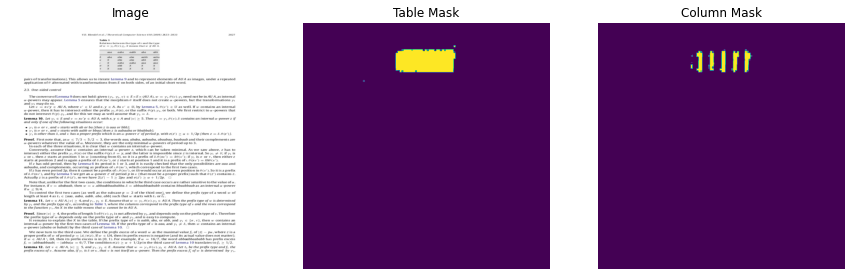

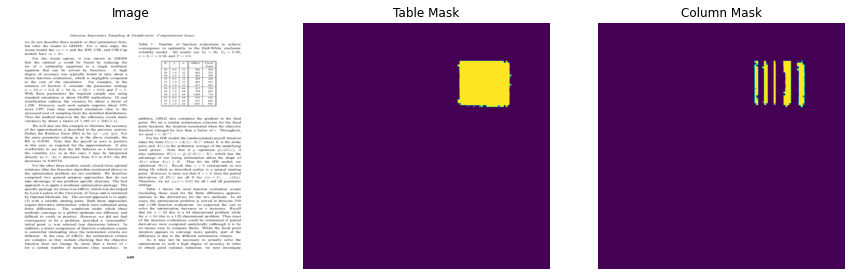

In [ ]:
number = 10
for image, mask  in test_dataloader.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image)
  table_mask, column_mask = get_mask(mask1),get_mask(mask2)
  image = image[0]
  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()

####  **Evaluating Performance :**

In [ ]:
model.load_weights("/content/model_save/weights-08-0.1101.hdf5")

In [ ]:
def f1_score(true, pred):
  ''' Returns F1-Score '''
  re = tf.keras.metrics.Recall()
  re.update_state(true, pred)
  re = re.result().numpy()

  pr = tf.keras.metrics.Precision()
  pr.update_state(true, pred)
  pr = pr.result().numpy()  

  f1 = 2*(re * pr)/(re + pr)
  return f1


In [ ]:
table , column = [] , []
predicted_table_mask , predicted_column_mask = list() , list()
for image, mask  in test_dataloader.take(Test.shape[0]):
  table.append(mask['Table_mask'][0])
  column.append(mask['Column_mask'][0])

  mask1, mask2 = model.predict(image)
  table_mask, column_mask = get_mask(mask1),get_mask(mask2)

  predicted_table_mask.append(table_mask)
  predicted_column_mask.append(column_mask)

In [ ]:
print("F1-Score for Table Masks : ",f1_score(table , predicted_table_mask))
print("-"*70)
print("F1-Score for Column Masks : ",f1_score(column , predicted_column_mask))

F1-Score for Table Masks :  0.9420742650539058
----------------------------------------------------------------------
F1-Score for Column Masks :  0.8512543315886713


####  **Extracting Data from Tables :**

In [19]:
def get_mask(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

In [ ]:
def table_detection(path) :
  """Detects and returns the table(s) in an image"""
  #reading  , resizing and normalizing for image data
  image = tf.io.read_file(path)
  image = tf.image.decode_bmp(image, channels=3)
  image = tf.image.resize(image, [1024, 1024])  #Decode a JPEG-encoded image to a uint8 tensor
  image = tf.cast(image, tf.float32) / 255.0 # normalizing image
    
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = get_mask(mask1), get_mask(mask2)

  im1=tf.keras.preprocessing.image.array_to_img(image)
  im1.save('/content/Testing/image.png')
        
  im2=tf.keras.preprocessing.image.array_to_img(table_mask)
  im2.save('/content/Testing/table_mask.png')
        
  im3=tf.keras.preprocessing.image.array_to_img(column_mask)
  im3.save('/content/Testing/column_mask.png')

  img_org = Image.open('/content/Testing/image.png')
  img_org = img_org.resize((1024,1024),Image.ANTIALIAS)

  print("\n")
  print('\033[1m' + "INPUT IMAGE :" + '\033[0m')
  print("\n")

  plt.figure(figsize=(10,40))
  plotting = plt.imshow(img_org,cmap='gray')
  plt.show()


  print("\n")
  print("-"*90)
  print("\n")

  print("\n")
  print('\033[1m' + "OUTPUT IMAGE :" + '\033[0m')
  print("\n")


  table_mask = Image.open('/content/Testing/table_mask.png')
  table_mask = table_mask.resize((1024,1024),Image.ANTIALIAS)
  col_mask = Image.open('/content/Testing/column_mask.png')
  #col_mask = col_mask.resize((1024,1024),Image.ANTIALIAS)

  img_mask = table_mask.convert('L')
  # img_mask = col_mask.convert('L')

  img_org.putalpha(img_mask)

  plt.figure(figsize=(10,40))
  plotting = plt.imshow(img_org,cmap='gray')
  plt.show()


  img_org.save('/content/Testing/output.png')

  return 

In [ ]:
def get_text():

  #read your file
  file=r'/content/Testing/output.png'
  img = cv2.imread(file,0)


  #thresholding the image to a binary image
  thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
  #inverting the image 
  img_bin = 255-img_bin
  cv2.imwrite('/content/Testing/cv_inverted.png',img_bin)

  # Length(width) of kernel as 100th of total width
  kernel_len = np.array(img).shape[1]//100
  # Defining a vertical kernel to detect all vertical lines of image 
  ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
  # Defining a horizontal kernel to detect all horizontal lines of image
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
  # A kernel of 2x2
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

  #Use vertical kernel to detect and save the vertical lines in a jpg
  image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
  vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
  cv2.imwrite("/content/Testing/vertical.jpg",vertical_lines)

  #Use horizontal kernel to detect and save the horizontal lines in a jpg
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
  cv2.imwrite("/content/Testing/horizontal.jpg",horizontal_lines)

  # Combine horizontal and vertical lines in a new third image, with both having same weight.
  img_vh = cv2.addWeighted(vertical_lines, 0.9, horizontal_lines, 0.1, 0.0 )
  #Eroding and thesholding the image
  img_vh = cv2.erode(~img_vh, kernel, iterations=2)
  thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY)
  cv2.imwrite("/content/Testing/img_vh.jpg", img_vh)
  bitxor = cv2.bitwise_xor(img,img_vh)
  bitnot = cv2.bitwise_not(bitxor)

  im1=tf.keras.preprocessing.image.array_to_img(bitnot[:,:,np.newaxis])
  im1.save('/content/Testing/image1.png')


  img_mask = Image.open('/content/Testing/column_mask.png')
  img_mask = img_mask.resize((1024,1024),Image.ANTIALIAS)

  img_mask = img_mask.convert('L')
  im1 = Image.open('/content/Testing/image1.png')
  im1 = im1.resize((1024,1024),Image.ANTIALIAS)

  im1.putalpha(img_mask)
  im1.save('/content/Testing/image1.png')


  print("\n")
  print("-"*90)
  print("\n")
  print('\033[1m' + "RETRIEVED TEXT :" + '\033[0m')
  print("\n")
  
  text_list = pytesseract.image_to_string(Image.open('/content/Testing/image1.png'), lang='eng' )
  text_list = text_list.split('\n')
  while("" in text_list)  :
    text_list.remove("")
  while(" " in text_list)  :
    text_list.remove(" ")
  while("  " in text_list) :
    text_list.remove("  ")

  for i in text_list:
    print(i)  

In [ ]:
!rm -rf ./content/Testing

**EXAMPLE 1 :**



INPUT IMAGE :




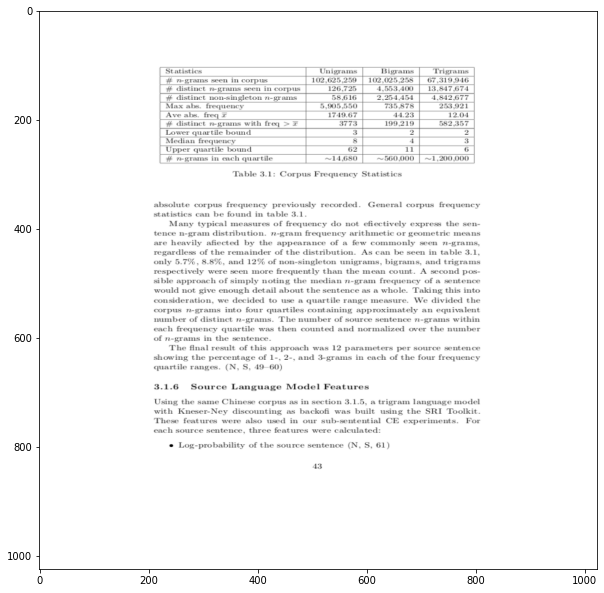



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




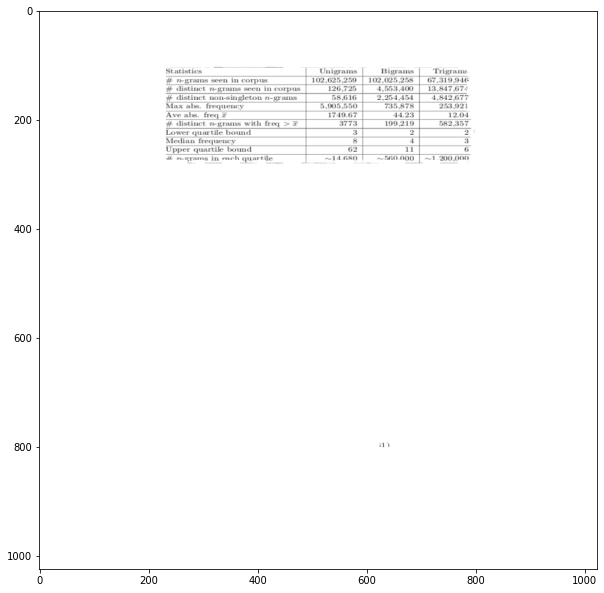



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


wtatisties Unigram Bigram ‘Trigram:
# ne-grams seen in corpus 52,625.25: 02.025.25' 7.319.940
# distinct r-grams seen in corpu 126,72) 4.55340) 13,847,672
# distinct non-singleton n-grams SSG18 = 9.254451 4.842.677
Max abs. frequency 5,905,550 735,878 253,921
Ave abs. freq F 1749.67 44.23 12.02
# distinct n-grams with freq > 7 3773 199,219 582.357
Lower quartile bound 3 2 2
Median frequency 3 4 3
Upper quartile bound @ ii 6
% merame in each anartile Ta aRO roan an8
RADON



In [ ]:
table_detection('/content/Data/10.1.1.1.2139_44.bmp')

get_text()

**EXAMPLE 2:**



INPUT IMAGE :




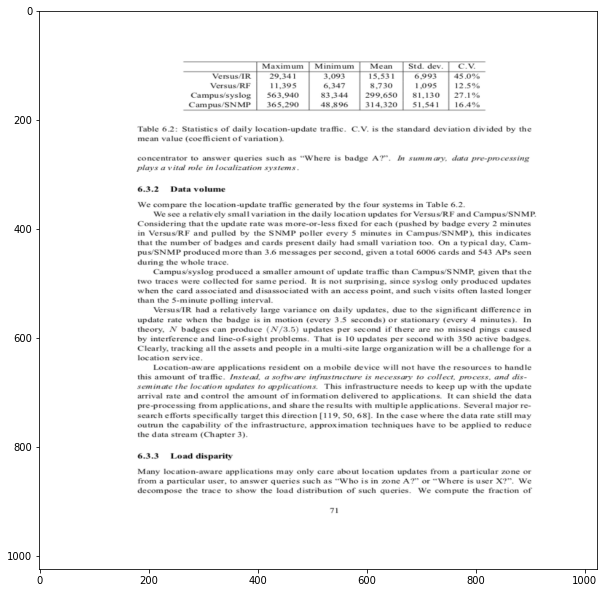



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




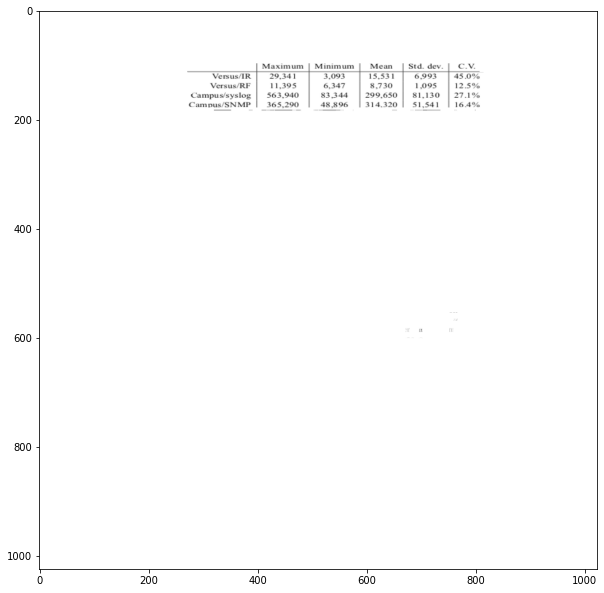



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


aximun — flinimur = Mean Std.dev CV.
Versusik 29,341 3,093 i5,531 6.993 15.0%
Versus/RE 11,395 6,347 8,730 1,095 12.5%
Campus/syslog 563,946 33.344 299,650 81,130 27.1%
Sampus/SNMI 365.290 18.896 14.320 51.541 16.4%



In [ ]:
table_detection('/content/Data/10.1.1.1.2076_85.bmp')

get_text()

**EXAMPLE 3:**



INPUT IMAGE :




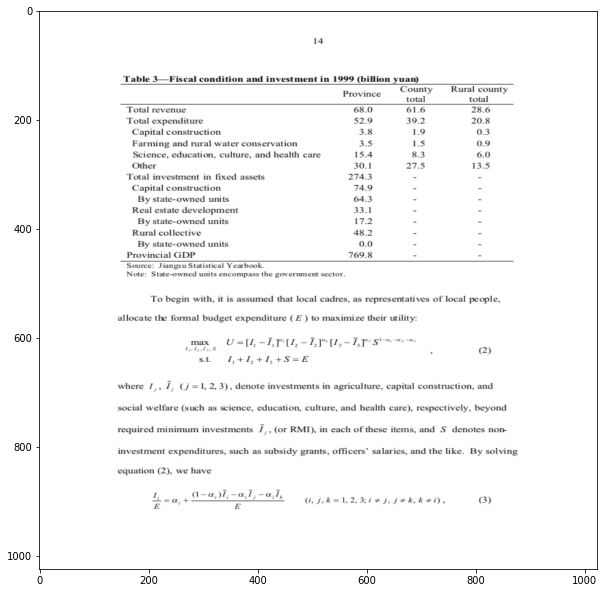



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




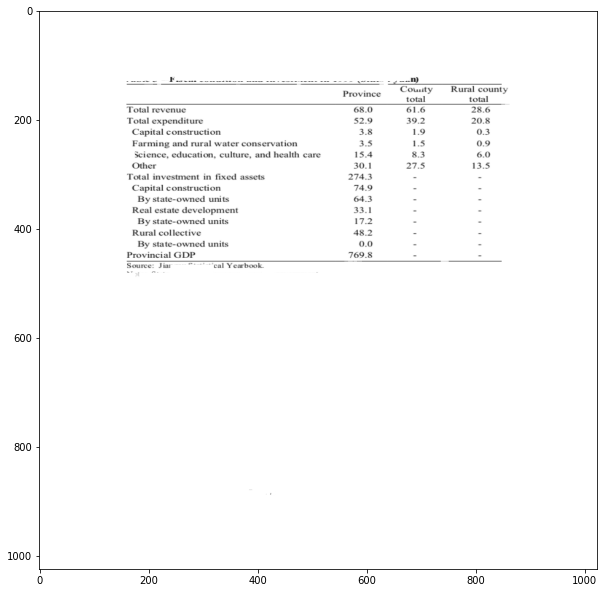



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


   
unity > ural county
total total
Total revenue 68.0 61.6 28.6
Total expenditure 52.9 39.2 20.8
Capital construction 3.8 1.9 0.3
arming and rural water conservation 3.5 1s 0.9
Science, education, culture, and health care 15.4 8.3 6.0
Other 30.1 27.5 13.5
Total investment in fixed assets 274.3 - -
Capital construction 74.9 - -
By state-owned units 64.3 - -
Real estate development 33.1 - -
By state-owned units 17.2 - -
Rural collective 48.2 - -
By state-owned units 0.0 - -
Provincial GDP 769.8 - -
cal Yearbook



In [ ]:
table_detection('/content/Data/10.1.1.1.2084_18.bmp')

get_text()

**EXAMPLE 4:**



INPUT IMAGE :




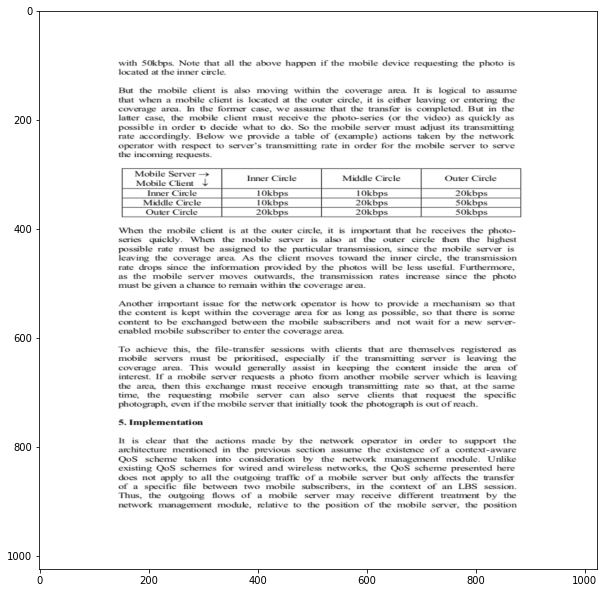



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




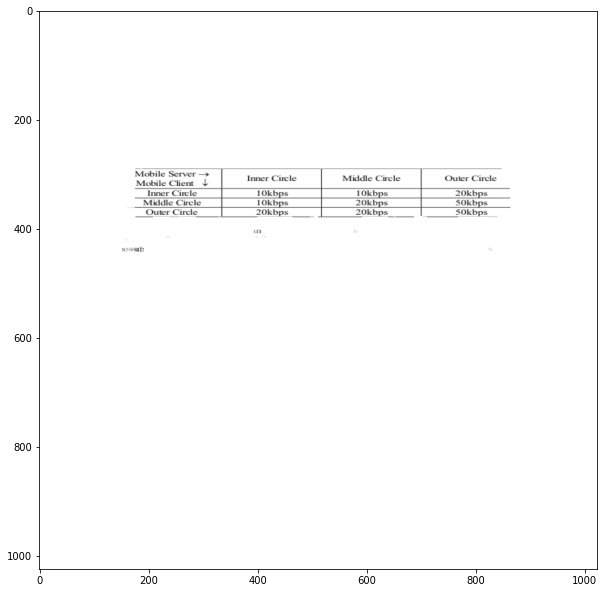



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


Movile Server — Inner Circle Middle Circ Suter Circle
Mobile Client +
Inner Circle 10kbps 10kbps 2Okbps
7 Middle Cirle 1Okbps 20kbps SO0kbps
‘Outer Circle 20kbps 20kbps SOkbps



In [ ]:
table_detection('/content/Data/10.1.1.6.2366_6.bmp')

get_text()

**EXAMPLE 5:**



INPUT IMAGE :




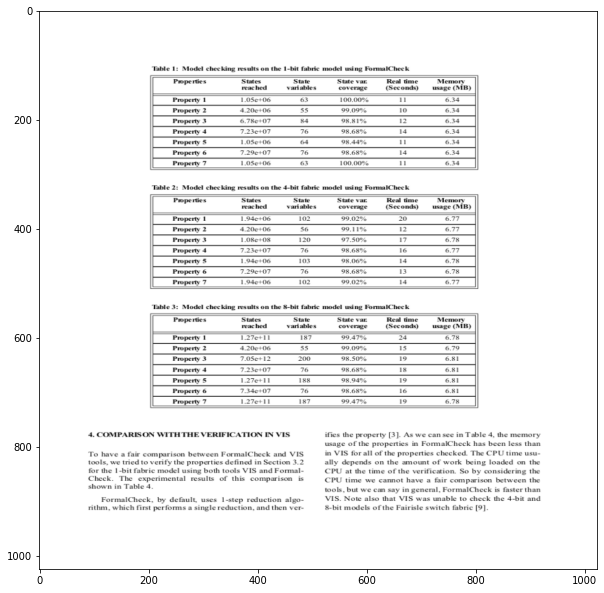



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




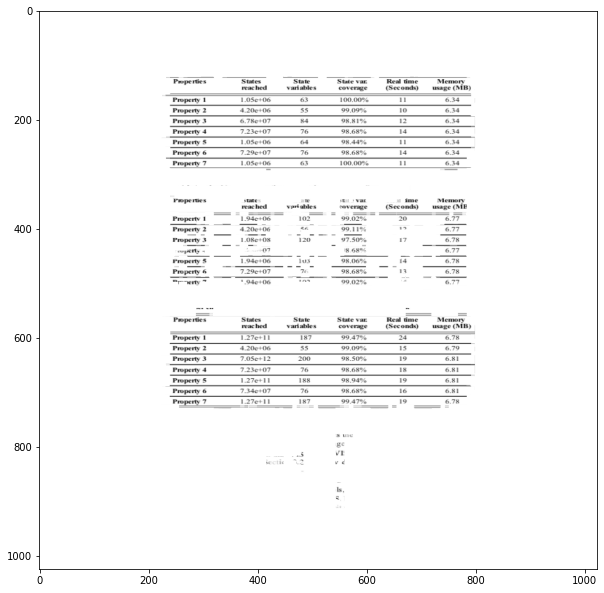



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


vere Peached ariables Seconds) sage (Nit
Propery 1 1056108 @ 17 oa
Property 2 206106 35 To 634
Property 3 6.78007 ea 2 634
Propeny 4 723607 76 = 638
Property 5 1.056106 @ I 634
Propeny 6 7296007 76 1 634
Propery7_ "1.050106 rs] mm 634
wen States Sam frum = aemony,
reached artables Seconds) swage (1B)
Propet Toasv06 TO 30 a7
Property 2 4.206706 36 2 677
Propeny 3 TORE OR 120 7 G78
Proper 4 723607 76 16 77
Property 5 794606 103 12 oR
Propeny 6 7296007 76 3 678
Property 7 T9606 02 13 77
Pueperties States State ‘tate vaz «Real tm. _sfemory
reached vartables —covermge Seconds) ange (MB)
Propers 1 Taye 137 a oe
Property 2 4206106 35 73 a
Propeny 3 Tasers 200 1B oa
Property 4 7236007 76 1s car
Property 5 T27eet 88 1 a
Propeny 6 734007 76 16 a7
T27erH 187 9 678



In [ ]:
table_detection('/content/Data/10.1.1.8.2156_5.bmp')

get_text()

**EXAMPLE 6:**



INPUT IMAGE :




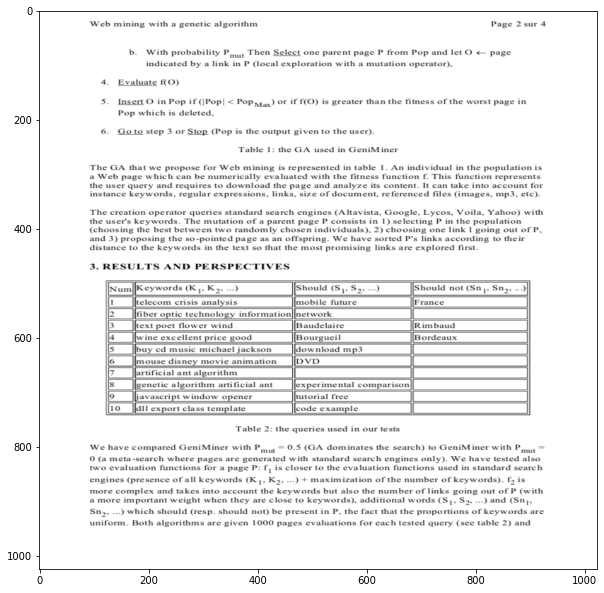



------------------------------------------------------------------------------------------




OUTPUT IMAGE :




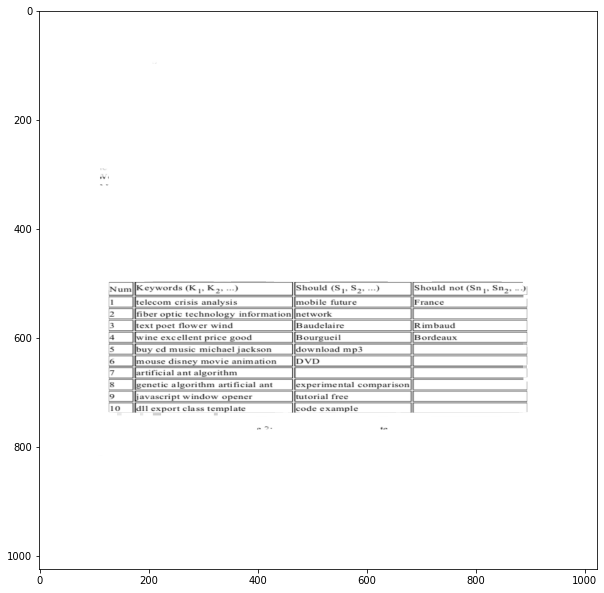



------------------------------------------------------------------------------------------


RETRIEVED TEXT :


Ne teywords (Ky. K Should (S;. 53. Should not (Sn, Sny,
1 elecom crisis analysis mobile future france
2 ‘iber optic technology informatio: network
3 ext poet flower wind Baudelaire "tim baud.
4 vine excellent price good Bourgue: 3ordeaux
S yuy cd music michael jackson download mp3
6 nouse disney movie animation VD
7 irtificial ant algorithm
8 tenetic algorithm artificial ant experimental compari
9 avascript window opener tutorial free
16 ill export class template code example



In [ ]:
table_detection('/content/Data/10.1.1.12.797_2.bmp')

get_text()

### **TableNet(Using ResNet50 Encoder) :**

In [ ]:
class tbl_decoder(tf.keras.layers.Layer):
  def __init__(self, name = "Table_mask"):
    super().__init__(name = name)
    self.conv1 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.umsample1 = UpSampling2D(size = (2,2),)
    self.umsample2 = UpSampling2D(size = (2,2),)
    self.umsample3 = UpSampling2D(size = (2,2),)
    self.umsample4 = UpSampling2D(size = (2,2),)
    self.convtranspose = Conv2DTranspose( filters=3, kernel_size=3, strides=2, padding = 'same')

  def call(self, X):

    input,pool_3,pool_4 = X[0],X[1],X[2]
    x = self.conv1(input)
    x = self.umsample1(x)
    x = concatenate([x, pool_4])
    x = self.umsample2(x)
    x = concatenate([x, pool_3])
    x = self.umsample3(x)
    x = self.umsample4(x)
    x = self.convtranspose(x)

    return x

class col_decoder(tf.keras.layers.Layer):
  def __init__(self, name = "Column_mask"):
    super().__init__(name = name)
    self.conv1 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.drop  = Dropout(0.8)
    self.conv2 = Conv2D(filters=512, kernel_size=(1,1), activation='relu')
    self.umsample1 = UpSampling2D(size = (2,2),)
    self.umsample2 = UpSampling2D(size = (2,2),)
    self.umsample3 = UpSampling2D(size = (2,2),)
    self.umsample4 = UpSampling2D(size = (2,2),)
    self.convtranspose = Conv2DTranspose( filters=3, kernel_size=3, strides=2, padding = 'same')

  def call(self, X):

    input,pool_3,pool_4 = X[0],X[1],X[2]
    x = self.conv1(input)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.umsample1(x)
    x = concatenate([x, pool_4])
    x = self.umsample2(x)
    x = concatenate([x, pool_3])
    x = self.umsample3(x)
    x = self.umsample4(x)
    x = self.convtranspose(x)

    return x

In [ ]:
input = Input(shape=(1024,1024,3))

resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input, classes=1000)

x = resnet50.output
pool_3 = resnet50.get_layer('conv3_block4_out').output # (128,128)
pool_4 = resnet50.get_layer('conv4_block6_out').output # (64,64)

x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(x)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)


Table_Decoder  = tbl_decoder()
Column_Decoder = col_decoder()

output1 = Table_Decoder([x, pool_3, pool_4])
output2 = Column_Decoder([x, pool_3, pool_4])

model = Model(inputs = input, outputs= [output1,output2], name = "TableNet")
model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "TableNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 512, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1_conv[0][0]                 
__________________________

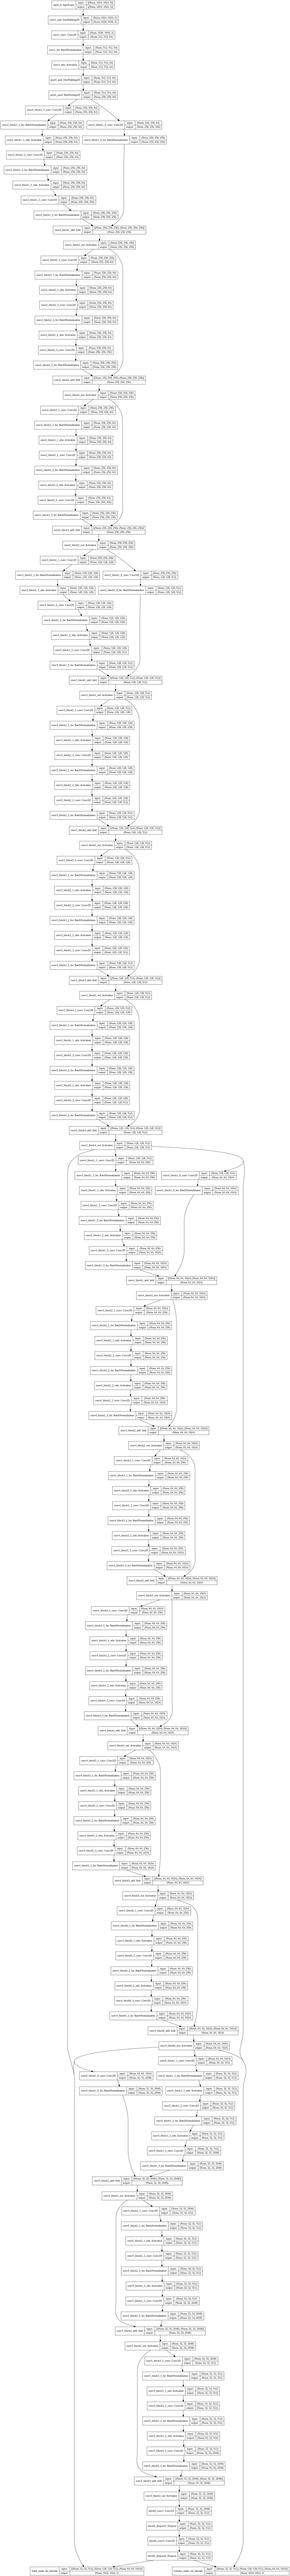

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
losses = {"Table_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
          "Column_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)}

loss_weights = {"Table_mask" : 1.0, 
                "Column_mask" : 1.0}

model.compile(optimizer= tf.keras.optimizers.Adam(0.0001, beta_1=0.8), loss = losses, loss_weights=loss_weights, metrics = ['accuracy']) #, F1Score(num_classes=2, threshold=0.5)])

In [ ]:
train_dataloader, test_dataloader, train_steps, val_steps = load_data(BATCH_SIZE = 1, BUFFER_SIZE = 10)

In [ ]:
filepath="model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,  monitor='val_loss' ,save_best_only=True, mode='auto', verbose = 1 )


hist = model.fit(train_dataloader, epochs =10, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/10
395/395 [==============================] - 326s 713ms/step - loss: 0.4377 - Table_mask_loss: 0.2283 - Column_mask_loss: 0.2094 - Table_mask_accuracy: 0.9007 - Column_mask_accuracy: 0.8943 - val_loss: 0.6143 - val_Table_mask_loss: 0.3057 - val_Column_mask_loss: 0.3087 - val_Table_mask_accuracy: 0.8907 - val_Column_mask_accuracy: 0.8847

Epoch 00001: val_loss improved from inf to 0.61433, saving model to model_save/weights-01-0.6143.hdf5
Epoch 2/10
395/395 [==============================] - 276s 700ms/step - loss: 0.2332 - Table_mask_loss: 0.1217 - Column_mask_loss: 0.1115 - Table_mask_accuracy: 0.9433 - Column_mask_accuracy: 0.9282 - val_loss: 0.7908 - val_Table_mask_loss: 0.3580 - val_Column_mask_loss: 0.4328 - val_Table_mask_accuracy: 0.8642 - val_Column_mask_accuracy: 0.8015

Epoch 00002: val_loss did not improve from 0.61433
Epoch 3/10
395/395 [==============================] - 276s 698ms/step - loss: 0.1824 - Table_mask_loss: 0.0939 - Column_mask_loss: 0.0885 - Table_mas

In [ ]:
hist2 = model.fit(train_dataloader, epochs =20, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/20
395/395 [==============================] - 275s 697ms/step - loss: 0.0915 - Table_mask_loss: 0.0370 - Column_mask_loss: 0.0545 - Table_mask_accuracy: 0.9754 - Column_mask_accuracy: 0.9500 - val_loss: 0.4080 - val_Table_mask_loss: 0.1522 - val_Column_mask_loss: 0.2558 - val_Table_mask_accuracy: 0.9460 - val_Column_mask_accuracy: 0.8815

Epoch 00001: val_loss did not improve from 0.35150
Epoch 2/20
395/395 [==============================] - 275s 696ms/step - loss: 0.0780 - Table_mask_loss: 0.0283 - Column_mask_loss: 0.0497 - Table_mask_accuracy: 0.9789 - Column_mask_accuracy: 0.9520 - val_loss: 0.5363 - val_Table_mask_loss: 0.1293 - val_Column_mask_loss: 0.4069 - val_Table_mask_accuracy: 0.9552 - val_Column_mask_accuracy: 0.8028

Epoch 00002: val_loss did not improve from 0.35150
Epoch 3/20
395/395 [==============================] - 275s 695ms/step - loss: 0.0733 - Table_mask_loss: 0.0264 - Column_mask_loss: 0.0469 - Table_mask_accuracy: 0.9797 - Column_mask_accuracy: 0.9528 -

In [ ]:
hist2 = model.fit(train_dataloader, epochs =40, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/40
395/395 [==============================] - 274s 694ms/step - loss: 0.0428 - Table_mask_loss: 0.0127 - Column_mask_loss: 0.0302 - Table_mask_accuracy: 0.9840 - Column_mask_accuracy: 0.9578 - val_loss: 0.6487 - val_Table_mask_loss: 0.3517 - val_Column_mask_loss: 0.2970 - val_Table_mask_accuracy: 0.8772 - val_Column_mask_accuracy: 0.8615

Epoch 00001: val_loss did not improve from 0.29779
Epoch 2/40
395/395 [==============================] - 274s 695ms/step - loss: 0.1471 - Table_mask_loss: 0.0822 - Column_mask_loss: 0.0649 - Table_mask_accuracy: 0.9642 - Column_mask_accuracy: 0.9460 - val_loss: 0.7213 - val_Table_mask_loss: 0.3232 - val_Column_mask_loss: 0.3981 - val_Table_mask_accuracy: 0.8829 - val_Column_mask_accuracy: 0.8218

Epoch 00002: val_loss did not improve from 0.29779
Epoch 3/40
395/395 [==============================] - 274s 694ms/step - loss: 0.0963 - Table_mask_loss: 0.0431 - Column_mask_loss: 0.0532 - Table_mask_accuracy: 0.9732 - Column_mask_accuracy: 0.9503 -

In [ ]:

train_dataloader, test_dataloader, train_steps, val_steps = load_data(BATCH_SIZE = 1, BUFFER_SIZE = 10)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.00001, beta_1=0.8), loss = losses, loss_weights=loss_weights, metrics = ['accuracy']) #, F1Score(num_classes=2, threshold=0.5)]

hist2 = model.fit(train_dataloader, epochs =40, steps_per_epoch=train_steps, \
          validation_data=test_dataloader, validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/40
269/395 [===================>..........] - ETA: 1:21 - loss: 0.0586 - Table_mask_loss: 0.0202 - Column_mask_loss: 0.0384 - Table_mask_accuracy: 0.9818 - Column_mask_accuracy: 0.9544

In [ ]:
model2 = model
model.load_weights("/content/model_save/weights-03-0.2601.hdf5")

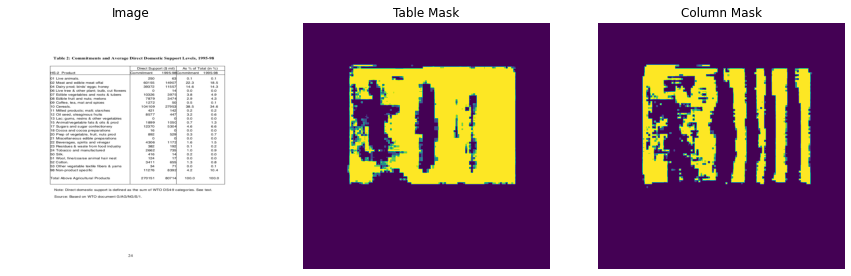

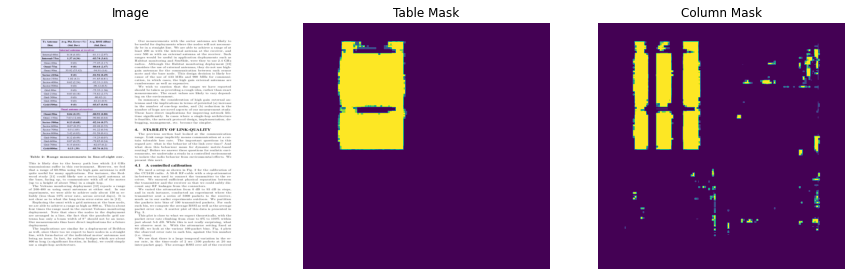

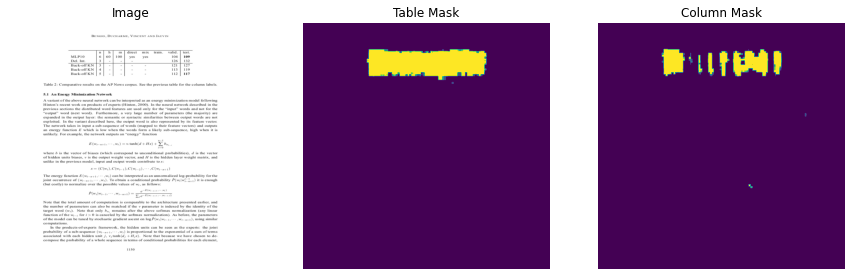

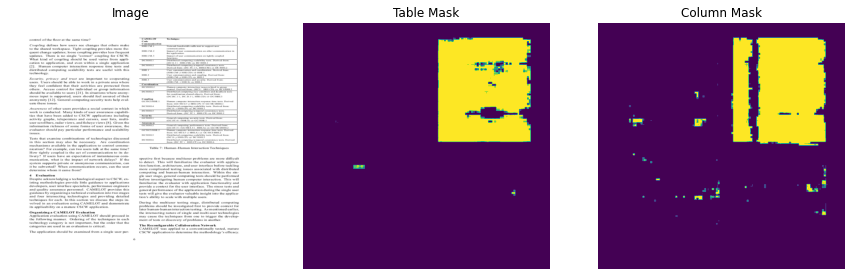

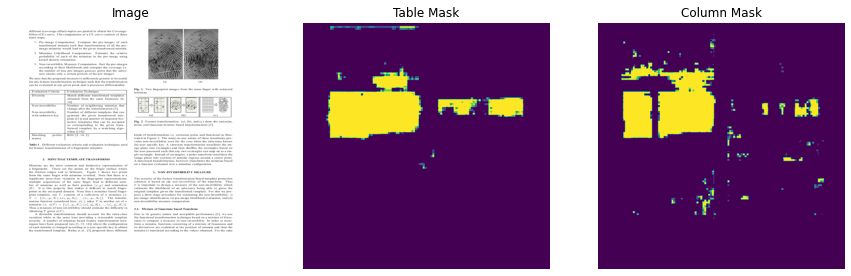

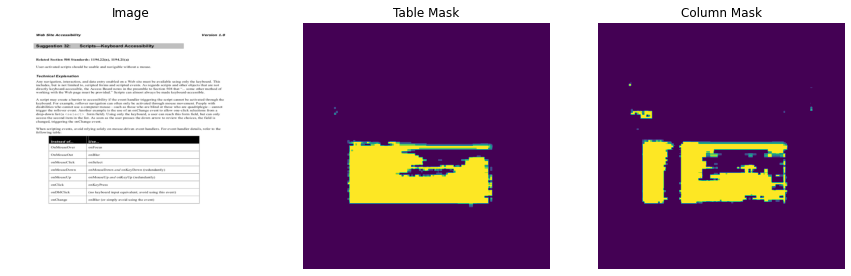

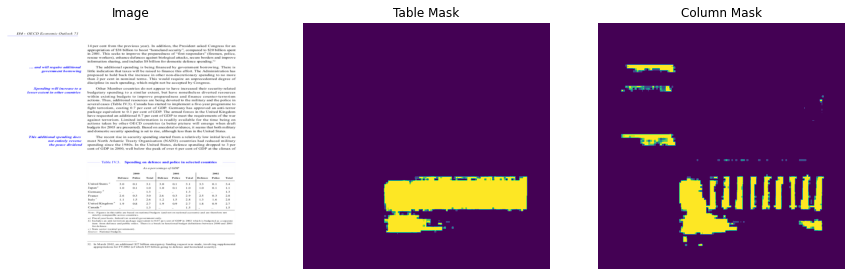

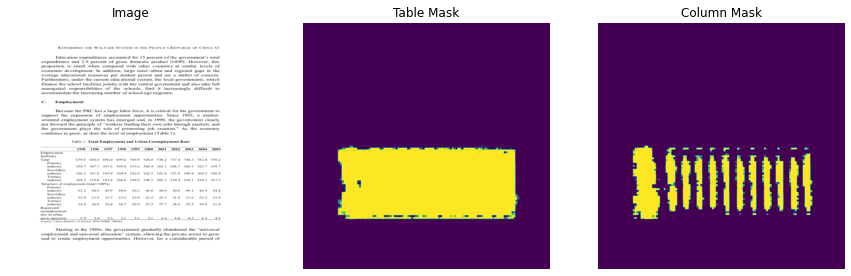

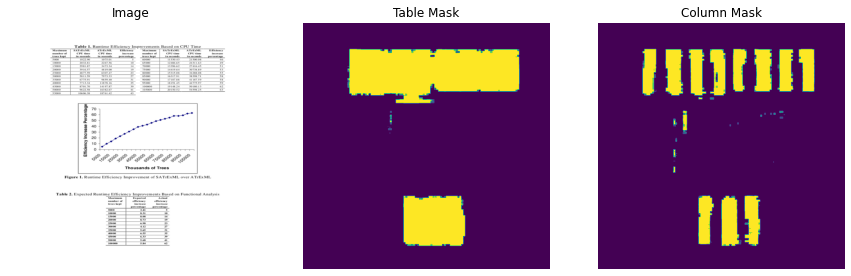

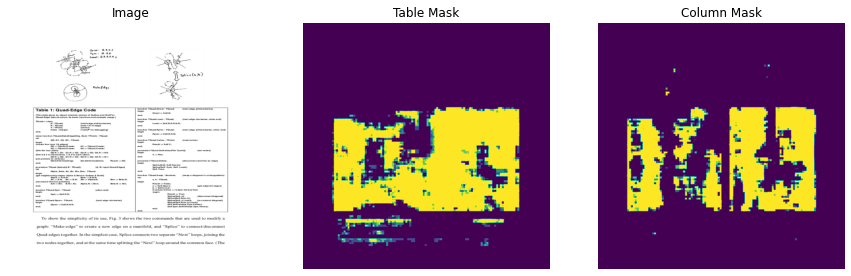

In [ ]:
number = 10
for image, mask  in test_dataloader.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image)
  table_mask, column_mask = get_mask(mask1),get_mask(mask2)
  image = image[0]
  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()